# CYCLOPS on Hughes Liver Data (Sparse PCA: scikit-learn)

This notebook explores the application of CYCLOPS on Hughes Liver data.

## 1. Importing packages

In [1]:
from cyclops_v2 import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Loading data

Read the Hughes Liver data into a pandas dataframe:

In [2]:
df = pd.read_csv("Hughes_2009_liver_new.csv").T
df = df.iloc[1:,:]

In [3]:
ng = df.shape[1]
nc = df.shape[0]
print("Running on {} genes and {} cells.".format(ng,nc))

Running on 9471 genes and 48 cells.


## 3. Data Preprocessing

Filter genes in the top -% variance:

In [4]:
frac = 1.00

df_std = pd.DataFrame(df.std().sort_values(ascending=False))
df_std = df_std.iloc[:round(df_std.shape[0]*frac),:]
df_std.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9471 entries, 8364 to 541
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       9471 non-null   float64
dtypes: float64(1)
memory usage: 148.0 KB


In [5]:
gene_list = df_std.index.to_numpy()
gene_list

array([8364, 2413, 5070, ..., 8475, 5102,  541])

In [6]:
data = df.to_numpy().T

newdata = np.zeros([len(gene_list),nc])
for i in range(len(gene_list)):
    newdata[i] = data[gene_list[i]]
newdata = pd.DataFrame(newdata.T)
newdata.shape

(48, 9471)

Before performing dimensionality reduction, the dataset has to be __centered__ to zero mean:

In [7]:
df_cent = df.transform(lambda x: x-x.mean())
df_cent.head()

,0,1,2,3,4,5,6,7,8,9,...,9461,9462,9463,9464,9465,9466,9467,9468,9469,9470
GSM301348,0.014731,0.023379,-0.225463,0.0256213,-0.091977,-0.0986038,0.1268,0.0572121,-0.0662028,0.144161,...,-0.187009,0.61696,-0.165423,-0.0783161,-0.0249054,-0.225493,0.380249,-0.213417,-0.0333318,-0.282134
GSM301349,0.0477128,0.0683699,-0.192851,0.00135615,-0.0734897,-0.093364,0.122528,-0.189258,-0.146086,0.144269,...,-0.181058,0.544616,-0.229702,-0.596752,0.0180488,-0.146045,-0.291389,0.145032,-0.0159358,-0.344121
GSM301350,0.0263479,0.109111,-0.277354,-0.0510575,-0.138075,-0.0584898,0.0696878,-0.118299,-0.0393214,0.0470119,...,-0.100364,0.488401,-0.00753027,-0.27712,-0.167578,-0.212268,0.00250341,-0.273931,-0.0290262,-0.271522
GSM301351,0.0488966,0.0787745,-0.257453,-0.0222759,-0.0964445,0.0323935,-0.13166,0.105324,-0.093984,-0.0102602,...,-0.156993,0.382649,-0.21871,-0.0727147,-0.0533745,0.0296482,-0.218331,-0.0898943,0.110628,-0.250211
GSM301352,-0.106043,-0.0356701,-0.292027,-0.0764265,-0.0614062,0.0610106,0.339653,0.192579,-0.00874023,-0.0764055,...,-0.104028,0.621035,0.00548999,0.0415891,-0.0107027,0.0387537,-0.121176,-0.116684,0.169825,-0.373472


## Sparse PCA

#### Perform sparse principal component analysis (SPCA)

The version of Sparse PCA implemented is an optimisation problem based on a PCA problem (dictionary learning) with an 
$l_1$-penalty on the components:
 
 $$
 (U^*,V^*) = \text{argmin}_{U,V}\hspace{0.15cm} \frac{1}{2}||X-UV||_2^2 + \alpha ||V||_1, \\
 \text{subject to}\hspace{0.35cm}  ||U_k||_2 = 1  \hspace{0.2cm}\text{     for all    }  \hspace{0.25cm}0\leq k<n_{components}
 $$

 	
 
 
The sparsity-inducing norm also prevents learning components from noise when few training samples are available. The degree of penalisation (and thus sparsity) was adjusted through the hyperparameter alpha, $\alpha$. Small values lead to a gently regularised factorisation, while larger values shrink many coefficients to zero.

Before conducting Sparse PCA, convert the dataframe into a numpy array:

In [8]:
data = df_cent.to_numpy()

#### Next, generate a sparse decomposition of the data using the scikit-learn library.

The number of sparse 'atoms' extracted was set to be half of the number of samples in the dataset, and the alpha (sparsity control parameter) was set to be 5.

In [9]:
frac = 0.5
n_components = round(frac*data.shape[0])
n_components

24

In [10]:
%%time

from sklearn.decomposition import SparsePCA

sparse_pca = SparsePCA(n_components=n_components, alpha=5, n_jobs=-1)
sparse_comp = sparse_pca.fit_transform(data)

CPU times: user 1.82 s, sys: 534 ms, total: 2.36 s
Wall time: 10.7 s


#### SPCA Eigengenes:

In [11]:
spca_eigengenes = pd.DataFrame(sparse_comp)
spca_eigengenes.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,-0.114398,-1.581961,0.331207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.352629,0.227784,1.596048,-0.446835,0.0
1,-0.055038,-1.843706,-0.438670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.363867,0.329062,1.004796,0.132719,0.0
2,-0.397212,-2.048815,-0.239747,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.196913,0.417735,0.774377,-1.117406,0.0
3,-1.657822,-2.422118,-0.999785,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.161197,0.276316,-0.542165,-0.505203,0.0
4,-1.179226,-2.654595,-1.361230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.284595,0.304009,0.249463,1.155878,0.0


Isolate non-zero columns as the eigengenes:

In [12]:
spca_eigengenes = spca_eigengenes.loc[:, (spca_eigengenes != 0).any(axis=0)]

In [13]:
print(spca_eigengenes.shape)
spca_eigengenes.head()

(48, 8)


,0,1,2,10,19,20,21,22
0,-0.114398,-1.581961,0.331207,-0.851494,-0.352629,0.227784,1.596048,-0.446835
1,-0.055038,-1.843706,-0.438670,-0.916454,-0.363867,0.329062,1.004796,0.132719
2,-0.397212,-2.048815,-0.239747,-0.484917,-0.196913,0.417735,0.774377,-1.117406
3,-1.657822,-2.422118,-0.999785,-2.006211,-0.161197,0.276316,-0.542165,-0.505203
4,-1.179226,-2.654595,-1.361230,-0.912921,-0.284595,0.304009,0.249463,1.155878


__Clip__ the values in each eigengene to remove outliers:

In [14]:
spca_eigengenes = spca_eigengenes.clip(np.percentile(spca_eigengenes, 5, axis=0), np.percentile(spca_eigengenes, 95, axis=0), axis=1)
spca_eigengenes.head()

,0,1,2,10,19,20,21,22
0,-0.114398,-1.581961,0.331207,-0.851494,-0.352629,0.227784,1.536920,-0.446835
1,-0.055038,-1.843706,-0.438670,-0.916454,-0.360574,0.329062,1.004796,0.132719
2,-0.397212,-2.048815,-0.239747,-0.484917,-0.196913,0.346953,0.774377,-1.102444
3,-1.613979,-2.422118,-0.999785,-1.352804,-0.161197,0.276316,-0.542165,-0.505203
4,-1.179226,-2.654595,-1.361230,-0.912921,-0.284595,0.304009,0.249463,1.155878


Sort the eigengenes in descending order of variance:

In [15]:
eig_std = np.array(spca_eigengenes.std().sort_values(ascending=False).index)
eig_std

array([ 1,  2, 22,  0, 10, 21, 19, 20])

Reorder the columns of the dataframe in descending order of variance:

In [16]:
spca_eigengenes = spca_eigengenes[eig_std]

Plot the three eigengenes with the largest variance:

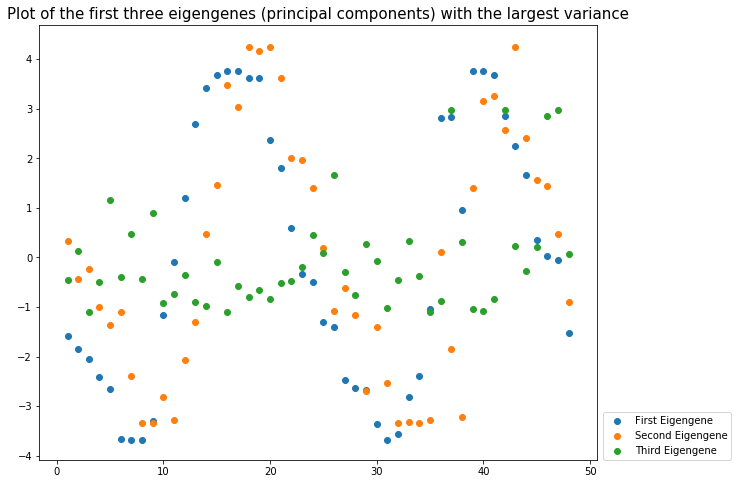

In [17]:
times = np.linspace(1,nc,nc)

eg1 = spca_eigengenes.iloc[:,0]
eg2 = spca_eigengenes.iloc[:,1]
eg3 = spca_eigengenes.iloc[:,2]

plt.figure(figsize=(10,8))
plt.scatter(times, eg1, label="First Eigengene")
plt.scatter(times, eg2, label="Second Eigengene")
plt.scatter(times, eg3, label="Third Eigengene")
plt.title('Plot of the first three eigengenes (principal components) with the largest variance', size=15)
plt.legend(loc=[1.01,0])
plt.show()

Next, plot these three eigengenes against each other:

Text(0.5, 1.0, '2nd vs 3rd')

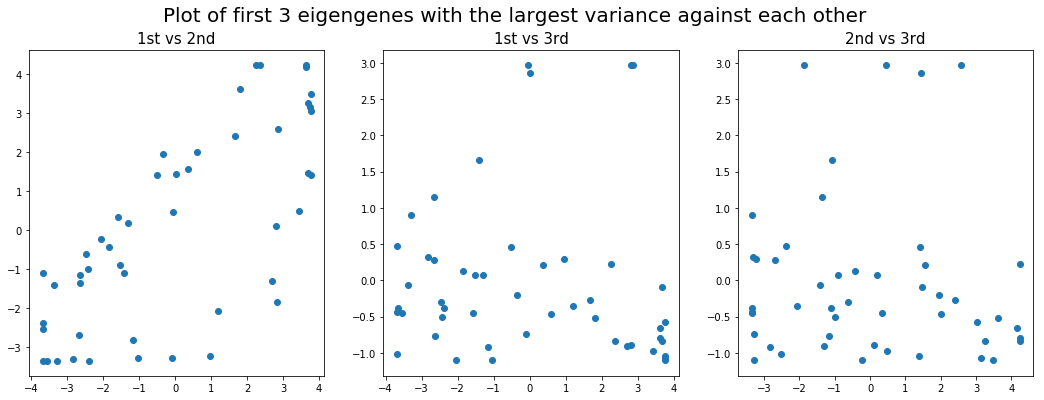

In [18]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18,6))
plt.suptitle('Plot of first 3 eigengenes with the largest variance against each other', size=20)

ax1.scatter(eg1, eg2)
ax1.set_title('1st vs 2nd', size=15)
ax2.scatter(eg1, eg3)
ax2.set_title('1st vs 3rd', size=15)
ax3.scatter(eg2, eg3)
ax3.set_title('2nd vs 3rd', size=15)

## 4. Creating the autoencoder model

In [19]:
data = spca_eigengenes.to_numpy()

In [20]:
model = cyclops(data.shape[1])

In [21]:
model.model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 8)]          0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 8)            0           input_layer[0][0]                
__________________________________________________________________________________________________
hidden_input (Dense)            (None, 5)            45          dropout[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 5)            0           hidden_input[0][0]               
_______________________________________________________________________________________

### Training the model

In [22]:
history = model.train(data[np.random.permutation(data.shape[0]), :], epochs=200, verbose=10, batch_size=10)

epoch: 10/200, loss: -0.5983, time elapsed:  0.72s, time left:  13.60s
epoch: 20/200, loss: -0.7591, time elapsed:  0.81s, time left:  7.25s
epoch: 30/200, loss: -0.8001, time elapsed:  0.88s, time left:  4.98s
epoch: 40/200, loss: -0.8188, time elapsed:  0.95s, time left:  3.80s
epoch: 50/200, loss: -0.7802, time elapsed:  1.01s, time left:  3.03s
epoch: 60/200, loss: -0.8368, time elapsed:  1.07s, time left:  2.49s
epoch: 70/200, loss: -0.7802, time elapsed:  1.13s, time left:  2.09s
epoch: 80/200, loss: -0.8221, time elapsed:  1.19s, time left:  1.78s
epoch: 90/200, loss: -0.7808, time elapsed:  1.26s, time left:  1.54s
epoch: 100/200, loss: -0.8316, time elapsed:  1.32s, time left:  1.32s
epoch: 110/200, loss: -0.7875, time elapsed:  1.37s, time left:  1.12s
epoch: 120/200, loss: -0.8230, time elapsed:  1.43s, time left:  0.96s
epoch: 130/200, loss: -0.7844, time elapsed:  1.56s, time left:  0.84s
epoch: 140/200, loss: -0.7305, time elapsed:  1.66s, time left:  0.71s
epoch: 150/200

#### Plot the loss of the model to check if it has converged:

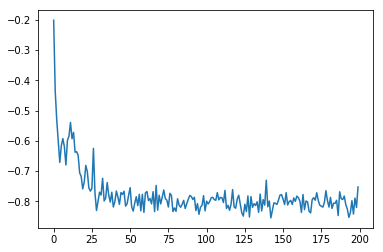

In [23]:
plt.plot(history.history['loss'])

## 5. Results and analysis

Print a dataframe of phase values generated from the autoencoder, and sort the rows according to increasing pseudotime values:

In [24]:
phase_df = model.phase_output(data)
phase_df.head()

,pseudotime
9,-2.969837
3,-2.714627
28,-2.671397
25,-2.455967
33,-2.410653


#### $z_p$ and $z_q$ are the values of each circular node in the bottleneck layer, from which the pseudotime (phase) values were extracted using argtan operations.

Next, print the lists of indices (which are the sample collection times) and phase values:

In [25]:
phase_idx = phase_df.index.to_numpy()
phase_list = phase_df.pseudotime.to_numpy()
phase_idx, phase_list

(array([ 9,  3, 28, 25, 33,  7,  8,  4, 34, 32,  6, 31, 27, 30,  2,  5, 26,
         1,  0, 29, 47, 24, 46, 45, 22, 23, 21, 44, 43, 20, 42, 40, 17, 39,
        19, 15, 18, 16, 41, 35, 38, 14, 13, 12, 36, 11, 37, 10]),
 array([-2.9698372 , -2.7146266 , -2.6713967 , -2.4559674 , -2.4106526 ,
        -2.3830538 , -2.3538048 , -2.3500712 , -2.2765536 , -2.270912  ,
        -2.2306418 , -2.1895018 , -2.1159968 , -2.0755289 , -2.0222402 ,
        -1.9375665 , -1.9325463 , -1.9241916 , -1.7385536 , -1.6388277 ,
        -1.4602175 , -1.4163427 , -0.790607  , -0.5315722 , -0.5292306 ,
        -0.46945158, -0.24205126,  0.03906371,  0.4227999 ,  0.53016174,
         0.69625586,  0.71055394,  0.75796574,  0.81635314,  0.89469767,
         0.97435635,  1.0069401 ,  1.0392237 ,  1.1566299 ,  1.1775237 ,
         1.2004466 ,  1.2503531 ,  1.4640907 ,  1.8798726 ,  1.9934503 ,
         2.4995465 ,  2.9185598 ,  2.9487088 ], dtype=float32))

### Plotting

Produce a polar plot of phase values:

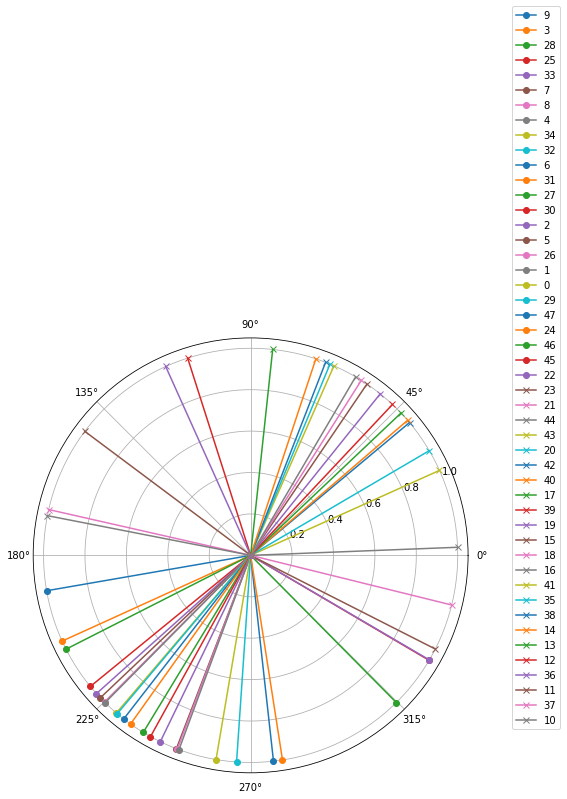

In [26]:
model.plot_polar(nc, phase_idx, phase_list)

Adjust and wrap phase values such that the phase at the first collection time (time 0) is zero:

In [27]:
idx = list(phase_idx).index(0)
phase_list -= phase_list[idx]

for i in range(len(phase_list)):
    if phase_list[i] > np.pi:
        phase_list[i] = -np.pi + (phase_list[i]-np.pi)
    elif phase_list[i] < -np.pi:
        phase_list[i] = np.pi - (-np.pi-phase_list[i])
        
phase_list

array([-1.2312835 , -0.9760729 , -0.9328431 , -0.7174138 , -0.672099  ,
       -0.64450014, -0.6152512 , -0.61151755, -0.538     , -0.5323583 ,
       -0.4920882 , -0.45094812, -0.3774432 , -0.33697522, -0.28368652,
       -0.19901288, -0.19399261, -0.18563795,  0.        ,  0.09972596,
        0.27833617,  0.3222109 ,  0.94794667,  1.2069814 ,  1.209323  ,
        1.2691021 ,  1.4965024 ,  1.7776173 ,  2.1613536 ,  2.2687154 ,
        2.4348094 ,  2.4491076 ,  2.4965193 ,  2.5549068 ,  2.6332512 ,
        2.71291   ,  2.745494  ,  2.7777772 ,  2.8951836 ,  2.9160774 ,
        2.9390001 ,  2.9889069 , -3.080541  , -2.664759  , -2.5511813 ,
       -2.0450852 , -1.6260718 , -1.5959228 ], dtype=float32)

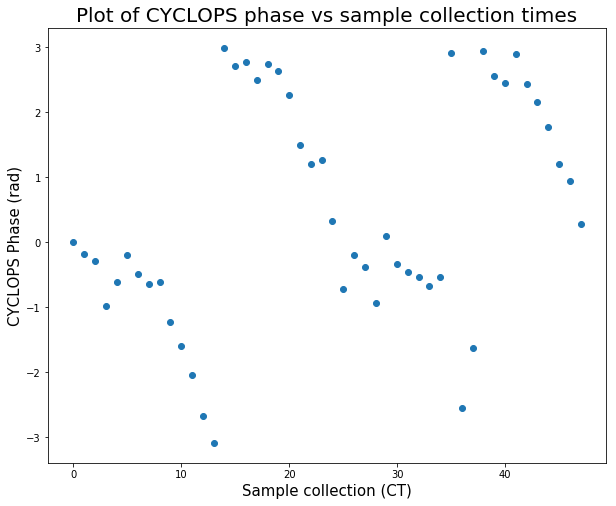

In [28]:
model.plot_phase_time(phase_idx, phase_list)

### Remapping

Create a dictionary of remapped sample indices according to increasing phase values:

In [29]:
remap_dict = model.remap(nc,phase_idx)

### Processing

Re-ordering the samples from the original dataset:

In [30]:
ori = df.to_numpy().T

new = np.zeros([ng,nc])
for i in range(ng):
    for key, val in remap_dict.items():
        new[i][val-1] = ori[i][key-1]

In [31]:
new.shape

(9471, 48)

#### Define a sinusoidal function to fit the reordered gene expressions. The function takes 4 parameters: intercept, amplitude, frequency and phase difference:

In [32]:
def test_func(x, dist, amp, omega, phi):
    return dist + amp * np.sin(omega * x + phi)

#### Create a curve fitting function that fits an optimal sinusoid to expression data for every gene:

In [33]:
from scipy import optimize
def fit_(f, xdata, ydata):
    try:
        popt, pcov = optimize.curve_fit(f, xdata, ydata)

        #Residual sum of squares (ss_res):
        residuals = ydata- f(xdata, *popt)
        ss_res = np.sum(residuals**2)

        #Total sum of squares (ss_tot):
        ss_tot = np.sum((ydata-np.mean(ydata))**2)

        r_squared = 1 - (ss_res / ss_tot)   
            
        return popt, pcov, r_squared

    except:
        pass

#### Store the parameter, covariance and $R^2$ values in arrays:

In [34]:
%%time

params, pcov = np.zeros([ng,4]), np.zeros([ng,4,4])
r_squared = np.zeros(ng)

for i in range(ng):
    try:
        params[i] = fit_(test_func, phase_list, new[i])[0]
        pcov[i] = fit_(test_func, phase_list, new[i])[1]
        r_squared[i] = fit_(test_func, phase_list, new[i])[2]
    except:
        continue

CPU times: user 1min 9s, sys: 647 ms, total: 1min 10s
Wall time: 1min 17s


In [35]:
params.shape, pcov.shape, r_squared.shape

((9471, 4), (9471, 4, 4), (9471,))

####  Create a dataframe of parameter and $R^2$ values and print:

_Note: if optimal parameters cannot be found for a particular gene, the parameter and $R^2$ values will be zero._

In [36]:
df_params = pd.DataFrame(params, columns=['intercept', 'amplitude', 'frequency', 'phase_shift'])
df_params['r_squared'] = r_squared

Sort the dataframe in descending order of $R^2$ values:

In [37]:
df_params = df_params.sort_values(by='r_squared', ascending = False)
df_params.head()

,intercept,amplitude,frequency,phase_shift,r_squared
8364,8.511250,2.517745,0.944899,-1.417327,0.921604
3572,8.499073,-0.968295,1.088700,1.484521,0.897170
953,11.037915,1.099671,0.998522,2.625272,0.895408
2107,9.940057,0.460472,0.976426,2.358881,0.891493
7062,7.784842,1.179327,0.873499,1.742553,0.888861


#### Plot the expression for the top 9 genes with the highest $R^2$ values:

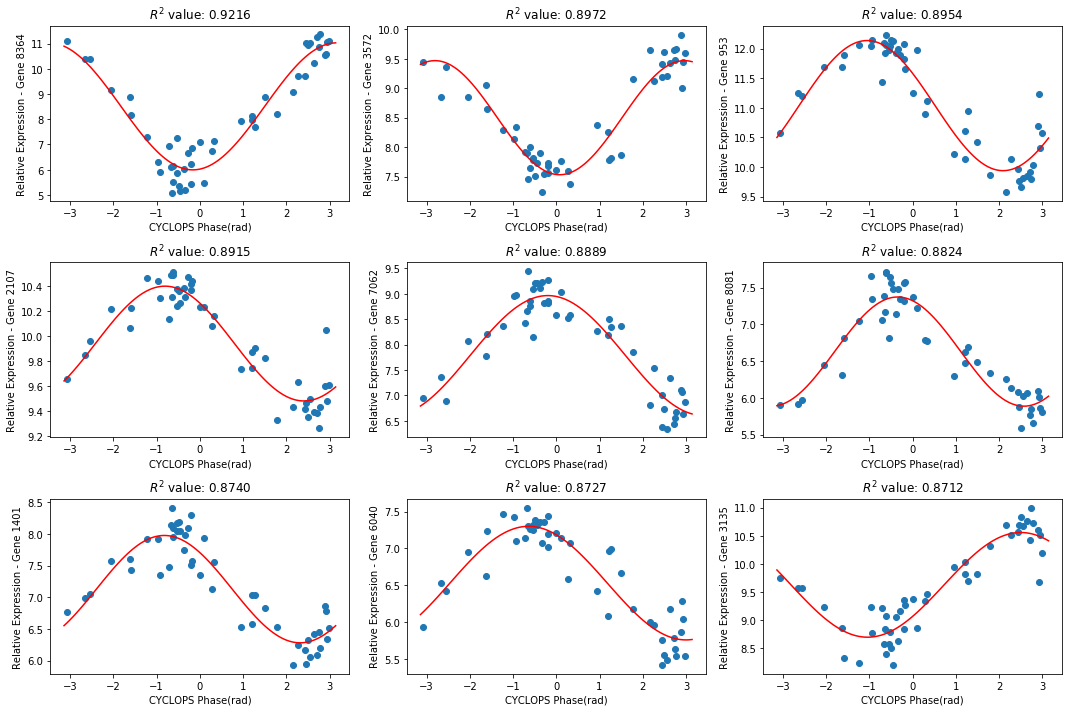

In [38]:
x = np.linspace(-np.pi,np.pi,100)

fig = plt.figure(figsize=(15,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.scatter(phase_list, new[df_params.index[i]])
    plt.plot(x, df_params.intercept.iloc[i]+df_params.amplitude.iloc[i]*np.sin(df_params.frequency.iloc[i]*x+df_params.phase_shift.iloc[i]), c='red')        
    plt.xlabel('CYCLOPS Phase(rad)')
    plt.ylabel('Relative Expression - Gene {}'.format(df_params.index[i]))
    plt.title('$R^2$ value: {:.4f}'.format(df_params.r_squared.iloc[i]))
    plt.tight_layout()

### Evaluating fit using R^2 values

#### Print the collection time indices reordered according to increasing index collection time values:

In [39]:
phase_df = model.phase_output(data)
phase_idx = phase_df.index.to_numpy()
phase_list = phase_df.pseudotime.to_numpy()

re_phase_idx = phase_df.sort_index().index.to_numpy()
re_phase_list = phase_df.sort_index()['pseudotime'].to_numpy()

re_phase_idx, re_phase_list

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),
 array([-1.7385536 , -1.9241916 , -2.0222402 , -2.7146266 , -2.3500712 ,
        -1.9375665 , -2.2306418 , -2.3830538 , -2.3538048 , -2.9698372 ,
         2.9487088 ,  2.4995465 ,  1.8798726 ,  1.4640907 ,  1.2503531 ,
         0.97435635,  1.0392237 ,  0.75796574,  1.0069401 ,  0.89469767,
         0.53016174, -0.24205126, -0.5292306 , -0.46945158, -1.4163427 ,
        -2.4559674 , -1.9325463 , -2.1159968 , -2.6713967 , -1.6388277 ,
        -2.0755289 , -2.1895018 , -2.270912  , -2.4106526 , -2.2765536 ,
         1.1775237 ,  1.9934503 ,  2.9185598 ,  1.2004466 ,  0.81635314,
         0.71055394,  1.1566299 ,  0.69625586,  0.4227999 ,  0.03906371,
        -0.5315722 , -0.790607  , -1.4602175 ], dtype=float32))

#### Determine the indices of phase jumps (in either direction) of absolute value greater than pi:

In [40]:
asc_phase_jump, desc_phase_jump = [],[]
for i in range(len(re_phase_list)-1):
    if re_phase_list[i+1]-re_phase_list[i] > np.pi:
        desc_phase_jump.append(i)
    elif re_phase_list[i+1]-re_phase_list[i] < -np.pi:
        asc_phase_jump.append(i)
        
asc_phase_jump, desc_phase_jump

([], [9, 34])

#### Function to remove anomalous jumps caused by noise in reorderings:

In [41]:
def jump_control(X):
    X_ = X.copy()
    pop_list = []
    
    margin = 10
    for i in range(1,len(X)):
        if X[i]-X[i-1]<margin:
            pop_list.append(i)
    pop_list.sort(reverse=True)
    for i in pop_list:
        X_.pop(i)
    return X_

In [42]:
if len(asc_phase_jump) > len(desc_phase_jump):
    phase_jump = asc_phase_jump
else:
    phase_jump = desc_phase_jump
    

phase_jump = jump_control(phase_jump)
phase_jump 

[9, 34]

#### Phase plots with red markers for identified jumps:

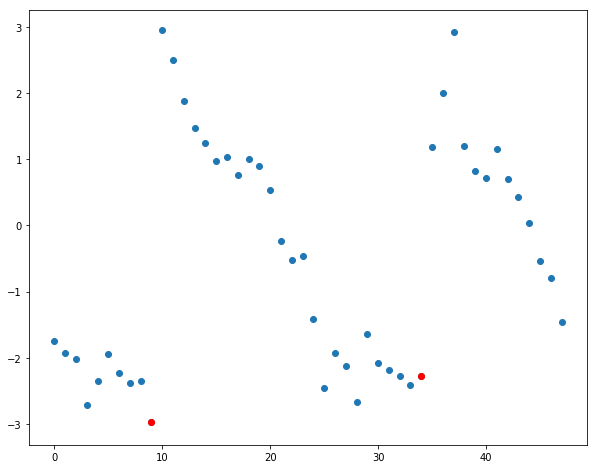

In [43]:
plt.figure(figsize=(10,8))
plt.scatter(re_phase_idx, re_phase_list)
plt.scatter(re_phase_idx[phase_jump], re_phase_list[phase_jump], marker='o', color="red")
plt.show()

#### Increment or decrement values in the phase list by 2pi based on the sign of the phase jumps:

In [44]:
jumps = len(phase_jump)
for i in range(jumps):
    if len(asc_phase_jump) > len(desc_phase_jump):
        re_phase_list = np.array([re_phase_list[i] if i < phase_jump[0]+1 else re_phase_list[i] + 2*np.pi for i in range(nc)])
    else:
        re_phase_list = np.array([re_phase_list[i] if i < phase_jump[0]+1 else re_phase_list[i] - 2*np.pi for i in range(nc)])
    phase_jump.pop(0)

#### Linear regression:

In [45]:
from scipy.stats import linregress

lin = linregress(re_phase_idx, re_phase_list)
lin

LinregressResult(slope=-0.25906352876746735, intercept=-1.082149589009167, rvalue=-0.9876672287383086, pvalue=1.0706892721845389e-38, stderr=0.006055066179036411)

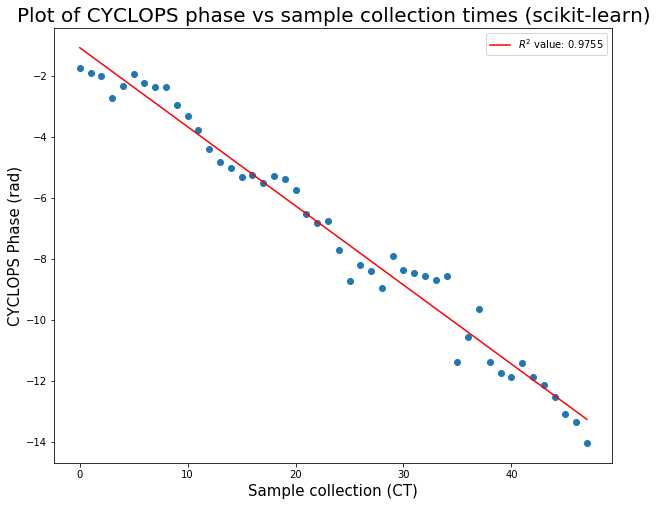

In [46]:
plt.figure(figsize=(10,8))
plt.scatter(re_phase_idx, re_phase_list)
plt.plot(re_phase_idx, lin[0]*re_phase_idx + lin[1], color='red', label='$R^2$ value: {:.4f}'.format(lin[2]**2))
plt.title(r'Plot of CYCLOPS phase vs sample collection times (scikit-learn)', size=20)
plt.xlabel('Sample collection (CT)', size=15)
plt.ylabel('CYCLOPS Phase (rad)', size=15)
plt.legend()
plt.show()